# Cord Cutting

We wanted to use reddit data to figure out the tendencies of cord-cutters: how they compare streaming services, what their concerns are with cable tv, their favorite shows and complaints with their streaming services. <br>

### Note
With text analytics, human intervention is required at many places since the results from these methods, although good, are not completely without some errors. Therefore, you will notice that at some places I have done some manual interventions. I will try to explain what was done.

In [1]:
import pandas as pd
import numpy as np
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from string import punctuation

import matplotlib.pyplot as plt
%matplotlib inline

## Extracting data from Reddit

We used [pushshift.io](https://pushshift.io/) to extract 4 months of reddit data. You can find the data [here](https://github.com/sagar-chadha/Data-Science-Projects/blob/master/Customer%20Sentiment%20Analysis/All%20Comments.xlsx)

### Pre- Requisites

We use the `praw` library for scraping reddit. `praw` is short for Python Reddit API Wrapper. To use this, you would need- 
   
*Knowledge of Python*:  
 	You need to know at least a little Python to use PRAW; it’s a Python wrapper after all. PRAW supports Python 2.7, and Python 3.3 to 3.6.
    
*Knowledge of Reddit:*   
 	A basic understanding of how reddit.com works is a must. In the event you are not already familiar with Reddit start with their FAQ.  
    
*A Reddit Account:*  
A Reddit account is required to access Reddit’s API. Create one at reddit.com. 

*Client ID & Client Secret:*  
 	These two values are needed to access Reddit’s API as a script application (see Authenticating via OAuth for other application types). If you don’t already have a client ID and client secret, follow Reddit’s First Steps Guide to create them.  
*User Agent:*  
A user agent is a unique identifier that helps Reddit determine the source of network requests. To use Reddit’s API, you need a unique and descriptive user agent.
    
[Source](https://praw.readthedocs.io/en/latest/getting_started/quick_start.html)

After creating the credentials (client_id, client_secret, username, password), the next step is to login into reddit API using praw package

In [ ]:
import praw
reddit = praw.Reddit(user_agent='Comment Extraction (by /u/USERNAME)',
                     client_id='********', client_secret="***********",
                     username='********', password='**********')

Here, we are creating an authorized reddit instance and not only the read-only instance as authorized instance has less restrictions in terms of data retrieval. The credentials are masked due to privacy and security reasons.

### Data extraction
Next, we send the requests to the reddit api and get the header and body of the comments as 2 separate lists.
 
The code first goes into the subreddit and then into the comment and gets all the replies and iterates the same process, till it reaches the end of the line in the sub reddit

In [ ]:
comm_list = []
header_list = []
i = 0
for submission in reddit.subreddit('cordcutters').hot(limit=2):
    submission.comments.replace_more(limit=None)
    comment_queue = submission.comments[:]  # Seed with top-level
    while comment_queue:
        header_list.append(submission.title)
        comment = comment_queue.pop(0)
        comm_list.append(comment.body)
        t = []
        t.extend(comment.replies)
        while t:
            header_list.append(submission.title)
            reply = t.pop(0)
            comm_list.append(reply.body)

In [ ]:
import pandas as pd
df = pd.DataFrame(header_list)
df['comm_list'] = comm_list
df.columns = ['header','comments']
df['comments'] = df['comments'].apply(lambda x : x.replace('\n',''))
df.to_csv('All comments.csv',index = False)

## Text Pre-processing
As with any other text field, the comments field has a lot of stuff that we don't want to include in our analysis - deleted comments, newline and carriage returns, english slangs, urls, etc. Let's remove these one by one before we proceed with any analysis of the data. 

Let's read in the data from the created excel file.

In [ ]:
df = pd.read_csv('All Comments.csv')
df.columns = ['subreddit', 'comments']
df['comments'] = df['comments'].astype('str')

**Step 1:** *Remove lines where comments says -removed*

In [3]:
# get and remove rows where comment has [removed]
mask_removed = df['comments'] == '[removed]'
df = df.loc[~mask_removed,:].reset_index(drop = True)

# get and remove rows where comment has [deleted]
mask_deleted = df['comments'] == '[deleted]'
df = df.loc[~mask_deleted,:].reset_index(drop = True)

**Step 2:** *Convert to lower case*

In [4]:
# Convert messages to lower case
df['comments'] = df['comments'].map(lambda x: x.lower())

**Step 3:** *Replace newline and carriage return characters*

In [5]:
def replace_newline(s):
    s = re.sub('\n', ' ',s)
    s = re.sub("\r", ' ',s)
    return s

df['comments'] = df['comments'].map(replace_newline)

**Step 4:** *Replace common english slang with full words*

In [6]:
def replace_slang(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["i'd", "you'd", "we'd","they'd", "i'll", "you'll", "we'll", "they'll", "i'm",
                  "y'all", "you're", "we're", "they're", "i've", "you've", "we've", "they've", "didn't", "shouldn't",
                 "couldn't", "wouldn't", "won't", "can't", "mustn't", "ain't", "isn't", "that's", "doesn't", "it'd",
                  "it'll", "/month", "/ month", "don't", "there's", "it's", "imo"]
    
    replace_with = ["i would", "you would", "we would", "they would", "i will", "you will", "we will", "they will",
                   "i am", "you all", "you are", "we are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not", "is not",
                   "that is", "does not", "it would", "it will", "per month", "per month", "do not", "there is", "it is",
                   "in my opinion"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

df['comments'] = df['comments'].map(replace_slang)

**Step 4:** *Remove urls*

In [7]:
# remove websites from comments
def remove_urls(s):
    s = re.sub("http[^\s]+", " ", s)
    s = re.sub("https[^\s]+", " ", s)
    s = re.sub("[^\s]+\.us[^\s]+", " ", s)
    s = re.sub("[^\s]+\.co.uk[^\s]+", " ", s)
    s = re.sub("[^\s]+\.com[^\s]+", " ", s)
    s = re.sub(" +", " ", s)
    return s

df['comments'] = df['comments'].map(remove_urls)

**Step 5:** *Change encoding to utf-8 to remove some unknown characters that have creeped into the comments*

In [8]:
def encode_decode(s):
    s = s.encode('ascii', errors = 'ignore').decode('utf-8')
    return s

# remove unknown characters
df['comments'] = df['comments'].map(encode_decode)

**Step 6:** *Remove apostrophes, stars (*) and extra spaces*

In [9]:
# remove apostrophes
def remove_apostrophe(s):
    s = re.sub("'", '',s)
    s = re.sub("\"", "", s)
    s = re.sub("\*", " ", s)
    s = re.sub("&gt;", " ", s)
    s = re.sub("&gt", " ", s)
    s = re.sub("&amp;#37;", "%", s)
    s = re.sub("&amp;", "&", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

# remove apostrophe
df['comments'] = df['comments'].map(remove_apostrophe)

**Step 7:** *Some slangs weren't caught last time.*

In [10]:
def replace_slang_again(s):
    '''replace commonly used phrases with the full thing'''
    to_replace = ["id", "youd", "theyd", "youll", "they'll", "im",
                  "yall", "youre", "theyre", "ive", "youve", "weve", "theyve", "didnt", "shouldnt",
                 "couldnt", "wouldnt", "wont", "cant", "mustnt", "aint", "isnt", "thats", "doesnt", "itd", "ill", "w/ live",
                 "w/live", "w/no", "itll", "/ month", "/month", "w/ no", "dont", "theres", "at&amp;t", "its"]
    
    replace_with = ["i would", "you would", "they would", "you will", "they will",
                   "i am", "you all", "you are", "they are", "i have", "you have", "we have", "they have", 
                    "did not", "should not", "could not", "would not", "will not", "cannot", "must not", "am not",
                   "is not", "that is", "does not", "it would", "i will", "with live", "with live", "with no", "it will",
                   "per month", "per month", "with no", "do not", "there is", "att" ,"it is"]
    
    for i in range(len(to_replace)):
        s = re.sub(r"\b%s\b" %to_replace[i], replace_with[i], s)
    
    return s

df['comments'] = df['comments'].map(replace_slang_again)

**Step 8:** *Remove parantheses*

In [11]:
# remove apostrophes
def remove_parantheses(s):
    s = re.sub("\(", ' ',s)
    s = re.sub("\[", ' ',s)
    s = re.sub("]", ' ',s)
    s = re.sub("\|", ' ', s)
    s = re.sub("\)", " ", s)
    s = re.sub("\^", " ", s)
    s = re.sub("#", " ", s)
    s = re.sub(" +", " ", s)
    s = s.rstrip().lstrip()
    return s

# remove apostrophe
df['comments'] = df['comments'].map(remove_parantheses)

**Step 8:** *Add space after full stops where it is directly followed by a character other than a space*

In [12]:
# Many comments have full stops not followed by any spaces. Lets correct this.
def fullstop_space(s):
    s = re.sub(r'(?<=[.,])(?=[^\s\.[0-9]])', r' ', s)
    return s

df['comments'] = df['comments'].map(fullstop_space)

**Step 9:** *Remove empty comments* <br>
These are comments that had just an unknown character in them

In [13]:
mask_empty = df['comments'] == ''
df = df.loc[~mask_empty, :]

**Step 10:** *Remove short comments* <br>
We wont gain much insights from comments less than 10 characters in length.

In [14]:
def flag_one_word(s):
    if len(s.split(' ')) <= 10:
        return True
    else:
        return False

mask_one_word = df['comments'].map(flag_one_word)

df = df.loc[~mask_one_word, :].reset_index(drop = True)

**Step 11:** *Clean service provider names* <br>
Service providers such as `Amazon Prime`, `Hulu` and others have been mentioned by various different names by different users. We need to clean these up so that we can reliably gauge consumer sentiment towards these services. <br>

For this purpose we have created an excel sheet with the various names mentioned in the comments under the column `Service_Name` and their corresponding corrected name under the column `Name_Mapping`. You can find this file in the Data Files folder in the repository.

In [15]:
# read in the text file
service_name_map = pd.read_excel('service_name_cleaning.xlsx')
service_name_map['Service_Name'] = service_name_map['Service_Name'].map(lambda x:x.lower())
service_name_map['Name_Mapping'] = service_name_map['Name_Mapping'].map(lambda x:x.lower())

# define the function
def clean_names(s):
    '''Given a string, this replaces the models mentioned in it by brands'''
    global service_name_map
    for i in range(len(service_name_map)):
        s = re.sub(r"\b%s\b" %service_name_map.loc[i, 'Service_Name'], service_name_map.loc[i, 'Name_Mapping'], s)
    return s

# replace all models by their brands
df['comments'] = df['comments'].map(clean_names)

### Write out the file to csv so that pre-processing doesnt have to be repeated.

In [16]:
df.to_csv('df_end_of_preproc.csv', index = False)

### Checkpoint 1

Read in already cleaned dataframe created above.

In [2]:
df = pd.read_csv('df_end_of_preproc.csv')

## Named entity recognition

Named entity recognition as the name suggests identification of entities like person, orgranization, location e.t.c from a particular sentence. It is a very crucial step for any sentiment analysis as it outputs the main entity that is present in the comment.  
For example, running Named entity recognition on a sentennce like "Microsoft is doing great in India" would output *Microsoft* as an organization and *India* as a location. 

In [ ]:
# Importing the data
import pandas as pd
df = pd.read_csv('df_end_of_preproc.csv')

### Extracting entities from the comments and storing them in a list
Steps followed:  
1. Install and import spacy package  
2. Write a function to extract the entities and their labels against each comment in the dataframe  

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

def ner(s):
    doc = nlp(s)
    l = []
    for ent in doc.ents:
        k = (ent.text,ent.label_)
        l.append(k)
    return l


df['entities_labels'] = df['comments'].apply(lambda x: ner(x))

Here, the main idea for extracting entites is to identify the organizations and persons that are involved in the comments. This would later help us understand in the maximum mentions for each entity in the data and the sentiment towards those entities.

In the below step, we have extracted the organization entities to use the same in Lift analysis where we found the association between the entities

In [ ]:
comm_list = list(df['comments'])
ents = []
labels = []
for comm in comm_list:
    doc = nlp(comm)
    for ent in doc.ents:
        ents.append(ent.text)
        labels.append(ent.label_)

temp = pd.DataFrame()
temp['ents'] = ents
temp['labels'] = labels

temp1 = temp[temp['labels'].isin(['ORG'])]
k = list(set(temp1['ents']))
temp2 = pd.DataFrame()
temp2['entities'] = k
temp2.to_csv('entities.csv')

It is good to note that although there are quite some misclassifications in terms of recognising the entities, achieving this from a pre-trained model is still satisfactory. 

**Next Steps:**  
This can be further improved if we can train an LSTM network on our data and use that model for future purposes on the same subreddit.

## What services are people mentioning? 

Let's begin with a very basic wordcloud of the services that people are mentioning the most

In [3]:
# create a corpus from all the comments
corpus = " ".join(df['comments'])

# get the tokens from this corpus
tokens = nltk.word_tokenize(corpus)

# extract english stopwords from nltk
en_stopwords = stopwords.words('english')

# remove stopwords from the corpus of comments
tokens_no_stopwords = [i.lower() for i in tokens if i.lower() not in en_stopwords]

# remove punctuations from the corpus of tokens
from string import punctuation
tokens_no_stop_no_punctuations = [i for i in tokens_no_stopwords if i not in punctuation]

# Calculate the frequency of the words in the corpus
freq_dist = nltk.FreqDist(tokens_no_stop_no_punctuations)

# create a list of words sorted by most frequent to least frequent
freq_word_list = sorted([(i,j) for i,j in freq_dist.items()], key = lambda x:x[1], reverse = True)

In [61]:
corpus_list = []
corpus_list.append(corpus)

np.savetxt("wordcloud.csv", corpus_list, delimiter=",", fmt='%s')

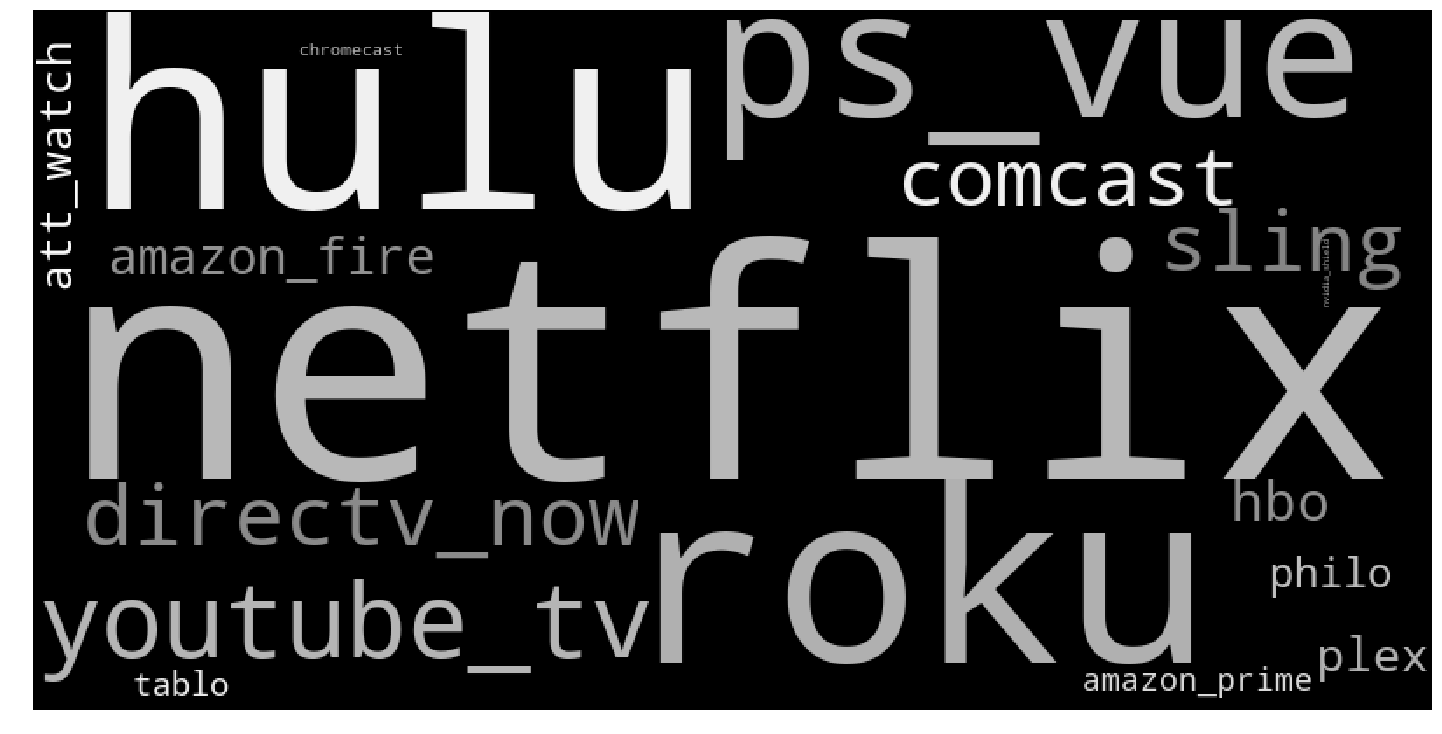

In [4]:
# Get a list of all service names
services = pd.read_excel('service_name_cleaning.xlsx')

services['Name_Mapping'] = services['Name_Mapping'].map(lambda x: x.lower())
find_services = services['Name_Mapping'].unique().tolist()

subdict = {x: freq_dist[x] for x in find_services if x in freq_dist}

# draw a wordcloud of the most mentioned services.
from wordcloud import WordCloud
import random

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

wordcloud = WordCloud(width= 800, height = 400,
                      relative_scaling = 1).generate_from_frequencies(subdict)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func=grey_color, random_state=3))
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The most talked about services are the ones that we expected - Amazon prime, roku, Netflix, youtube TV, etc. Next let's see what these users are saying about these services.

## Topic Modelling (Latent Dirichlet Analysis)

Before we dive into the analysis of sentiments, it makes sense to look at what people generally talk about on this forum. We use the concept of Latent Dirichlet Analysis, commonly called 'LDA' to analyze the topics in our comments. LDA works on the follwing assumptions - <br>
1. *The author of a document decides on the number of words to be included in a document.*
2. *Then, he decides the number of topics to be included in the document and their probabilities.*
3. *Finally, to write the document the author picks up a topic as per the probability and picks up words that fall under that topic.*

LDA tries to backtrack and extract the aforementioned 'topics' from a document and 'words' in that topic. For LDA analysis, two inputs are important - <br>
1. **How many topics dominate the document corpus?**
2. **How many words dominate each topic?**

Once these are mentioned, the algorithm goes ahead and finds the most dominant topics and their corresponding words.

In [1]:
import pandas as pd
import numpy as np
import string
import random

import nltk
from nltk import word_tokenize
from nltk.corpus import wordnet
import re

from nltk.stem import WordNetLemmatizer
word_lemm = WordNetLemmatizer()

from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

In [2]:
df = pd.read_csv('df_end_of_preproc.csv') # data with the pre-processing already done!

We should lemmatize our text. This takes care of multiple forms of the same word being treated separately. The following functions help in lemmatization.

In [3]:
def convert_to_valid_pos(x):
    """Converts the pos tag returned by the nltk.pos_tag function to a format accepted by wordNetLemmatizer"""
    x = x[0].upper() # extract first character of the POS tag
    
    # define mapping for the tag to correct tag.
    tag_dict = {"J": wordnet.ADJ,
               "N": wordnet.NOUN,
               "R": wordnet.ADV,
               "V": wordnet.VERB}
    
    return tag_dict.get(x, wordnet.NOUN)

def get_lemma(sentence):
    """Given a sentence, derives the lemmatized version of the sentence"""
    pos_tagged_text = nltk.pos_tag(word_tokenize(sentence))
    
    lemm_list = []

    for (word, tag) in pos_tagged_text:
        lemm_list.append(word_lemm.lemmatize(word, pos = convert_to_valid_pos(tag)))
    
    return lemm_list

def prepare_text_for_lda(text):
    """Lemmatizes text, removes stopwords and short words from given text."""
    lemm_list = get_lemma(text)
    
    tokens = [i for i in lemm_list if i not in en_stopwords]
    
    tokens = [token for token in tokens if len(token) > 4]
    
    return tokens

If required (in case this takes too much time) we can also look at taking only a proportion of all tokens present in the corpus

In [4]:
def siege(f, n):
    """Returns only n% of all tokens from a file. Provide - 
    n - fraction of documents to keep.
    f - filename"""
    
    text_data = []
    np.random.seed(42)
    
    with open(f, encoding="utf8") as f:
        for line in f:
            if random.random() > (1 - n):
                tokens = prepare_text_for_lda(line.split(",")[1])
                text_data.append(tokens)
    
    return text_data

In [5]:
# lets work with 70% of the tokens and create topics
text_data = siege('df_end_of_preproc.csv', 0.70)

In [6]:
# create a dictionary from the text data that we have. This creates an efficient internal system to quickly
# see which terms appear where and it what frequency
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [7]:
# LDA implementation
import gensim
i = 5

Topic_list =[]

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary, passes=15)
ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words = 20)
for topic in topics:
    Topic_list.append(topic[1])

In [9]:
# save the topics for later use.
df = pd.DataFrame({'col':Topic_list})

def clean_topic_words(x):
    """Clean topic words as output by the algorithm"""
    clean_topic = re.findall("\".*?\"", x)
    return clean_topic

df['col'] = df['col'].map(clean_topic_words)

df.to_csv("Topics_List.csv") # write out for later use

In [19]:
df

,col
0,"[""channel"", ""watch"", ""ps_vue"", ""local"", ""youtu..."
1,"[""cable"", ""internet"", ""antenna"", ""would"", ""pri..."
2,"[""antenna"", ""signal"", ""something"", ""neutrality..."
3,"[""would"", ""device"", ""amazon_fire"", ""apple"", ""g..."
4,"[""service"", ""month"", ""netflix"", ""watch"", ""cont..."


A glance at the topics generated shows that some trends emerge - <br>
1. People talk about net neutrality with words like neutrality, Jefferson, etc.
2. People talk about streaming services - ps vue, youtube tv, sling, etc.
3. People talk about traditional cable experience - antenna, cable, commercials, etc

## Sentiment Analyzer
The most common way to extract sentiments from text where there is no data with labels is to use a reference list of words with pre-defined sentiment scores attached to them. This approach has many limitations and therefore we use a more novel approach. This is a three step approach - <br>
1. **Extract bigrams using Parts of speech** - Look for meaningful bigrams such as - 'excellent service', 'great price', 'poor quality', etc. Keep only the top bigrams.
2. **Sentiment Mining** - <br>
    a. See which bigrams make their sentiments very clear. For instance, we know that 'excellent service' means a positive thing. Tag these bigrams with sentiments directly using the `VADER` library. <br>
    b. Next, we will use VADER to get positive and negative reference words from our corpus. <br>
    c. For the rest of the bigrams, calculate their association (lift) with reference positive (good, excellent, marvelous,etc) and reference negative words (poor, pathetic, etc.).
3. **Semantic Orientation** - For part `a` above, the sentiments are clear. For part `b`, use the difference of lift between the positive and negative words as the final sentiment score.

**Step 1:** *Extract bigrams using Parts of Speech tagging* <br>
Find consecutive trigrams that have pos tags as per certain conditions below and then extract the first two words of that trigram -

| Rule | First Word     | Second Word | Third Word (not extracted) |
|------|----------------|-------------|----------------------------|
| 1    | JJ (Adjective) | NN          | Anything                   |
| 2    | RB (Adverb)    | JJ          | Not NN                     |
| 3    | JJ             | JJ          | Not NN                     |
| 4    | NN (Noun)      | JJ          | Not NN                     |
| 5    | RB             | VB (Verb)   | Anything                   |

In [ ]:
def get_n_grams(string):
    '''Given a string, this forms trigrams using 3 consecutive words and 
    also gets tri-grams of the parts of speech tags. This will return bigrams which match the required patterns.'''
    
    # since we need trigrams
    n = 3
    
    # get the tokens in the provided string
    tokens_list = nltk.word_tokenize(string)
    
    # get pos_tags for each token
    pos_tag_list = [j for (i,j) in nltk.pos_tag(tokens_list)]
    
    # required to see where n-gram formation should stop
    list_length = len(tokens_list)
  
    # to store the n grams
    n_grams_tokens = []
    n_grams_postag = []
    
    # make n grams of pos_tags and tokens. n is 3
    for i in range(list_length - (n-1)):
        n_grams_tokens.append(" ".join(tokens_list[i:i+n]))
        n_grams_postag.append(" ".join(pos_tag_list[i:i+n]))
        
    # What are the bi-grams i am looking for
    req_bi_tags = ['JJ NN', 'JJ NNS', 'RB JJ', 'RBR JJ', 'RBS JJ', 'JJ JJ', 'NN JJ', 'NNS JJ',
                           'RB VB', 'RBR VB', 'RBS VB', 'RB VBD', 'RB VBN', 'RB VBG', 'RBR VBD', 'RBR VBN',
                           'RBR VBG', 'RBS VBD', 'RBS VBN', 'RBS VBG']
    
    # what are all possible pos tags
    all_pos_tags = ['CC', 'CD','DT','EX','FW','IN','JJ','JJR', 'JJS', 'LS','MD', 'NN','NNS','NNP','NNPS','PDT','POS','PRP',
                    'PRP$','RB','RBR','RBS','RP','SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP$','WRB']
    
    # required trigram tags
    req_tri_tags = [(i+' '+j) for i in req_bi_tags for j in all_pos_tags]
    
    # the following trigram combinations violate the rules
    not_consider = ['RB JJ NN', 'RB JJ NNS', 'RBR JJ NN', 'RBR JJ NNS', 'RBS JJ NN', 'RBS JJ NNS',
                    'JJ JJ NN', 'JJ JJ NNS', 'NN JJ NN', 'NN JJ NNS', 'NNS JJ NN', 'NNS JJ NNS']
    
    # remove the trigram tags that are not to be considered.
    req_tri_tags = list(set(req_tri_tags) - set(not_consider))
    
    
    # first we select trigrams that have pos tags that fall within the criteria defined above. Then we pick up the first
    # two elements of that trigram to get our ultimate list of bi_grams
    selected_tri_grams = []
    selected_bi_grams = []
    
    # whereever the pos_tag combination matches what we want, we pick those n-grams
    for j in range(len(n_grams_postag)):
        if n_grams_postag[j] in req_tri_tags:
            selected_tri_grams.append(n_grams_tokens[j])
        else:
            continue

    # take the first two words from the isolated trigram
    for i in selected_tri_grams:
        selected_bi_grams.append(" ".join(i.split(" ")[:2]))
    
    return selected_bi_grams

In [ ]:
# this function now returns all important bigrams in my comments. Lets run this for all comments and extract all good
# bigrams from these comments. Take unique of these bi-grams since bi-grams would repeat.

bi_gram_series = df['comments'].map(get_n_grams)
bi_gram_list = [j for i in bi_gram_series for j in i]

In [ ]:
# count how many times a bigram appears in the list of all bigrams
bi_gram_dict = {}

for i in list(set(bi_gram_list)):
    bi_gram_dict[i] = bi_gram_list.count(i)
    
freq_bigram_list = sorted([(i,j) for i,j in bi_gram_dict.items()], key = lambda x:x[1], reverse = True)

There are just TOO many bigrams that satisfy the requirements that we specified above. We would need to limit the bigrams we analyze since only the most common ones would be of any value. <br>

To that end let's take only the top 1500 bigrams for our analysis.

In [ ]:
subset_bigrams = [j[0] for i,j in enumerate(freq_bigram_list) if i < 1500]

**Remove services from shortlisted bigrams**

Sometimes, these service names are confused for some part of speech that they are not. Let's remove bigrams that capture the service names i.e. netflix, hulu, etc.

In [ ]:
# get a list of all unique service names
services = service_name_map['Name_Mapping'].unique().tolist()

# shortlist bigrams only where service name doesnt appear
shortlisted_bigrams = []

for i in subset_bigrams:
    mask = []
    for j in services:
        mask.append(j in i)
    if np.sum(mask) == 0:
        shortlisted_bigrams.append(i)

### Write out shortlisted bigrams to a csv

In [ ]:
import numpy as np
np.savetxt("shortlisted_bigrams.csv", shortlisted_bigrams, delimiter=",", fmt='%s')

### Checkpoint 2
Read in the selected bigrams from csv

In [ ]:
shortlisted_bigrams = pd.read_csv('shortlisted_bigrams.csv', header = None)
shortlisted_bigrams = shortlisted_bigrams.loc[:,0].tolist()

**Step 2:** *a) VADER sentiment scores for bigrams* <br>
We will now get VADER sentiment scores for all the bigrams and then pick those which have clear meanings manually.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

#Lets get VADER's perspective on the sentiments of our bigrams. We will use shortlisted bigrams for this exercise.

bigram_sentiment = {}

for bigram in shortlisted_bigrams:
    snt = analyser.polarity_scores(bigram)
    bigram_sentiment[bigram] = snt
    
bigram_sentiment_df = np.transpose(pd.DataFrame(bigram_sentiment))
bigram_sentiment_df.reset_index(inplace = True)

# remove where the compound sentiment is 0
mask_cs_0 = bigram_sentiment_df['compound'] == 0
bigram_sentiment_df = bigram_sentiment_df.loc[~mask_cs_0, :]

bigram_sentiment_df.to_csv('bigram_sentiment_vader.csv', index = False)

### Checkpoint 3
#### Read in VADER provided sentiment scores from csv

In [ ]:
# read in csv
bigram_sentiment_vader = pd.read_csv('bigram_sentiment_vader.csv')

# keep only these columns
bigram_sentiment_vader = bigram_sentiment_vader[['index', 'compound']]
bigram_sentiment_vader.columns = ['Bigram', 'Net_Sentiment']

**Step 2:** *b) VADER Sentiment Scores to get positive and negative words*

In [ ]:
# create a corpus from all the comments
corpus = " ".join(df['comments'])

# get the tokens from this corpus
tokens = nltk.word_tokenize(corpus)

# extract english stopwords from nltk
en_stopwords = stopwords.words('english')

# remove stopwords from the corpus of comments
tokens_no_stopwords = [i.lower() for i in tokens if i.lower() not in en_stopwords]

# remove punctuations from the corpus of tokens
from string import punctuation
tokens_no_stop_no_punctuations = [i for i in tokens_no_stopwords if i not in punctuation]

# VADER sentiments for words
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

#Lets get VADER's list of positive, negative and neutral words from my corpus
all_unique_tokens = list(set(tokens_no_stop_no_punctuations))

word_sentiment = {}

for word in all_unique_tokens:
    snt = analyser.polarity_scores(word)
    word_sentiment[word] = snt
    
sentiment_df = np.transpose(pd.DataFrame(word_sentiment))

#### Clean the words up, put them in a dataframe

In [ ]:
from string import punctuation

def remove_punctuation(s):
    for i in punctuation:
        s = s.replace(i, "")
    return s

# negative words list - words with 1 under the 'neg' column
negative_words = sentiment_df.loc[sentiment_df['neg'] > 0, 'neg'].index.values
negative_words = pd.Series(negative_words).map(remove_punctuation).drop_duplicates().tolist()
negative_words = [x for x in negative_words if x]

# positive words list - words with 1 under the 'pos' column
positive_words = sentiment_df.loc[sentiment_df['pos'] > 0, 'pos'].index.values
positive_words = pd.Series(positive_words).map(remove_punctuation).drop_duplicates().tolist()
positive_words = [x for x in positive_words if x]

# create dataframes for ease of use
negative_words_df = pd.DataFrame({'Word':negative_words,
                                 'Sentiment':np.repeat('negative', len(negative_words))})

positive_words_df = pd.DataFrame({'Word':positive_words,
                                 'Sentiment':np.repeat('positive', len(positive_words))})

# append negative and positive words into one big dataframe
all_words_sentiments = pd.concat([negative_words_df, positive_words_df], axis = 0, ignore_index=True)

### Write out word sentiments to csv
This is for use later.

In [ ]:
# write the positive and negative words onto a csv file
all_words_sentiments.to_csv('words_sentiments.csv', index = False)

### Checkpoint 4
Read in word_sentiments from csv

In [ ]:
all_words_sentiments = pd.read_csv('words_sentiments.csv')

Replace all positive sentiment words with the phrase 'positive' and negative sentiment words with the phrase 'negative'. This is so that calculating the association between the bigrams and the positive and negative reference words becomes easier.

In [ ]:
import re
def sentiment_by_phrase(s):
    '''Given a string, this replaces the positive and negative sentiment words mentioned in it by placeholder phrases'''
    global all_words_sentiments
    
    words_found = all_words_sentiments['Word'].map(lambda x: x in s)
    subset_df = all_words_sentiments.loc[words_found,:].reset_index(drop = True)

    for i in range(len(subset_df)):
        s = re.sub(r"\b%s\b" %subset_df.loc[i, 'Word'], subset_df.loc[i, 'Sentiment'], s)
    return s

# replace words by their sentiments - retain a copy of the original.
df_for_sentiment = df.copy()
df_for_sentiment['comments'] = df_for_sentiment['comments'].map(sentiment_by_phrase)

### Checkpoint 5
Output `df_for_sentiment` to csv

In [ ]:
df_for_sentiment.to_csv('df_for_sentiment.csv', index = False)

### Restore from checkpoint 5
Read in the df_for_sentiment from csv

In [ ]:
df_for_sentiment = pd.read_csv('df_for_sentiment.csv')

When we replaced the positive and negative words by placeholders, some of our original bigrams would have been damaged. This is why we create a copy of the original dataframe. We will use this dataframe only to get a 1/0 representation of which rows have the positive/negative placeholders. This will be overlayed with where the bigrams are and lift calculations would be done.

Let's remove the bigrams which have clear sentiments on their own and dont need lift calculations.

### Note - 
This is one of the places, I have manually made changes. So the file we create with VADER sentiment scores with bigrams `bigram_sentiment_vader`, had all bigrams with their VADER sentiment scores. I removed bigrams from it that had no clear negative or positive connotation.

In [ ]:
# already calculated are those that were analyzed by vader
sent_already_calculated = bigram_sentiment_vader['Bigram'].unique().tolist()

# remainder are what are in shortlisted but not in already calculated
sent_to_be_calculated = list(set(shortlisted_bigrams) - set(sent_already_calculated))

In [ ]:
# we have to find all so that we can calculate lift between services and bigrams later
bigram_to_find = sent_already_calculated + sent_to_be_calculated

# Check for bigram presence in comments
def check_for_bigram(s):
    global bigram_to_find
    
    answer = []
    
    for i in bigram_to_find:
        answer.append(int(i in s))
    
    return answer

# check each bi-gram and where it is found
found_bi_gram = df['comments'].map(check_for_bigram)

# create a dictionary to hold a bigram and index where it's found in the data.
bi_gram_dict= {}

for i in range(len(bigram_to_find)):
    bi_gram_dict[bigram_to_find[i]] = [j[i] for j in found_bi_gram]

# create a dataframe with columns as bi-grams and 1/0 as rows indicating presence.
found_bi_gram_df = pd.DataFrame(bi_gram_dict)

### Checkpoint 6
#### Write out found_bi_gram_df to csv

In [ ]:
found_bi_gram_df.to_csv('found_bi_gram_df.csv', index = False)

#### Read in found_bi_gram_df from csv

In [ ]:
found_bi_gram_df = pd.read_csv('found_bi_gram_df.csv')

**Step 2:** *c) Lift between remaining bigrams and the reference positive and negative words*
1. Represent `df_for_sentiment` as a bag of words and isolate the positive and negative columns.
2. Need to append the `found_bi_gram` dataframe to it column wise.
3. Get lift between all bigrams and positive and all bi-grams and negative.

In [ ]:
# Bag of words representation of the df_for_sentiments dataframe
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

# these are counts of all words in the messages
X = np.array(df_for_sentiment['comments'])
X_counts = count_vectorizer.fit_transform(X)

# column names for the counts
X_counts_matrix = np.where(X_counts.todense() > 0 , 1, 0)
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

count_df_for_sentiment = pd.DataFrame(X_counts_matrix, columns = column_names)
count_df_for_sentiment.head()

In [ ]:
# append count_df_for_sentiment with the dataframe having the locations of the bigrams
sentiment_df = count_df_for_sentiment[['positive', 'negative']]
bigram_sentiment_for_lift = pd.concat([sentiment_df, found_bi_gram_df], axis = 1)

In [ ]:
# get combinations of bigrams and words for which we need to calculate the lift
bigram_sentiment_combinations = [(i,j) for i in sent_to_be_calculated for j in ['positive', 'negative']]

In [ ]:
def calc_lift(df, pairs):
    '''Given a list of brand pairs, calculate the lift values between the two'''
    lift_values = []
    
    calc_df = df.copy()
    for i in range(len(pairs)):
        
        # sum means where both brands appear
        calc_df['sum'] = calc_df.loc[:,pairs[i]].apply(sum, axis = 1)
        
        # How many rows have both brands?
        count_both = (calc_df['sum'] == 2).sum()
        
        # how many rows have just the first brand
        count_first = calc_df[pairs[i][0]].sum()
        
        # how many rows have just the second brand
        count_second = calc_df[pairs[i][1]].sum()
        
        # get the lift value
        lift = (len(calc_df)*count_both)/(count_first * count_second)
        lift_values.append(lift)
    
    output_df = pd.DataFrame({'Bigram': [p[0] for p in pairs],
                             'Sentiment': [p[1] for p in pairs],
                             'Lift': lift_values})
    return output_df

# calculate lift between the different brands
lift_values = calc_lift(bigram_sentiment_for_lift, bigram_sentiment_combinations)

# sort lift by most to least
lift_values = lift_values.sort_values(['Bigram', 'Lift'], ascending = [True, False]).reset_index(drop = True)

**Step 4:** *Semantic Orientation for bigrams using difference of lifts*

In [ ]:
bigram_sentiment_net = lift_values.pivot(index = 'Bigram', columns = 'Sentiment', values = 'Lift').reset_index()
bigram_sentiment_net.columns = ['Bigram', 'Negative', 'Positive']

# drop NA values if any
bigram_sentiment_net.dropna(inplace = True, how = 'any')

bigram_sentiment_net['Net_Sentiment'] = np.log2(bigram_sentiment_net['Positive']) - np.log2(bigram_sentiment_net['Negative'])
bigram_sentiment_net.head()

In [ ]:
bigram_sentiment_net = bigram_sentiment_net[['Bigram', 'Net_Sentiment']]

# append the bigram_sentiment_df to the lift_pivot
all_bigram_sentiments = pd.concat([bigram_sentiment_net, bigram_sentiment_vader], axis = 0, ignore_index = True)

### Checkpoint 7
#### Write out `lift_pivot` to a csv file.

In [ ]:
# lift_pivot to a csv file.
all_bigram_sentiments.to_csv('all_bigram_sentiments.csv', index = False)

In [ ]:
# read lift_pivot from a csv.
all_bigram_sentiments = pd.read_csv('all_bigram_sentiments.csv')

## Get the bigrams most associated with service providers.
Now that we have got the sentiment scores for each bigram, the next step is to calculate the association between those bigrams and the services so that we know which ones are being said most about which company. <br>

Once this is done we will know which company is being talked about, what people are saying and whether its a good thing or bad!

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

# these are counts of all words in the messages
X = np.array(df['comments'])
X_counts = count_vectorizer.fit_transform(X)

# column names for the counts
X_counts_matrix = np.where(X_counts.todense() > 0 , 1, 0)
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

count_df = pd.DataFrame(X_counts_matrix, columns = column_names)
count_df.head()

In [ ]:
# read in the text file
service_name_map = pd.read_excel('service_name_cleaning.xlsx')
service_name_map['Service_Name'] = service_name_map['Service_Name'].map(lambda x:x.lower())
service_name_map['Name_Mapping'] = service_name_map['Name_Mapping'].map(lambda x:x.lower())

services = service_name_map['Name_Mapping'].unique().tolist()

# Check for service names present in comments
def check_for_services(s):
    global services
    answer = []
    
    for i in services:
        answer.append(int(i in s))
    
    return answer

# check each service and where it is found
found_services = df['comments'].map(check_for_services)

# create a dictionary to hold a service and index where it's found in the data.
services_dict= {}

for i in range(len(services)):
    services_dict[services[i]] = [j[i] for j in found_services]

# create a dataframe with columns as services and 1/0 as rows indicating presence.
found_services_df = pd.DataFrame(services_dict)

In [ ]:
# concatenate found_bi_gram_df and found_services_df
bigram_services_df = pd.concat([found_bi_gram_df, found_services_df], axis = 1)

# combinations to calculate lift for
service_bigram_combinations = [(i,j) for i in services for j in all_bigram_sentiments['Bigram'].tolist()]

# calculate the lift
def calc_lift(df, pairs):
    '''Given a list of brand pairs, calculate the lift values between the two'''
    lift_values = []
    
    calc_df = df.copy()
    
    for i in range(len(pairs)):
        
        # sum means where both brands appear
        calc_df['sum'] = calc_df.loc[:,pairs[i]].apply(sum, axis = 1)
        
        # How many rows have both brands?
        count_both = (calc_df['sum'] == 2).sum()
        
        # how many rows have just the first brand
        count_first = calc_df[pairs[i][0]].sum()
        
        # how many rows have just the second brand
        count_second = calc_df[pairs[i][1]].sum()
        
        # get the lift value
        lift = (len(calc_df)*count_both)/(count_first * count_second)
        lift_values.append(lift)
    
    output_df = pd.DataFrame({'Service': [p[0] for p in pairs],
                             'Bigram': [p[1] for p in pairs],
                             'Lift': lift_values})
    return output_df

# calculate lift between the different brands
bigram_service_lift = calc_lift(bigram_services_df, service_bigram_combinations)

# sort lift by most to least
bigram_service_lift = bigram_service_lift.sort_values(['Service', 'Lift'], ascending = [True, False]).reset_index(drop = True)

### Remove service-bigram combinations with 0 lift

In [ ]:
mask_lift_0 = bigram_service_lift['Lift'] == 0
bigram_service_lift = bigram_service_lift.loc[~mask_lift_0, :]

bigram_service_lift.head()

### Checkpoint 8

In [ ]:
# write out service bigram lift values to csv
bigram_service_lift.to_csv('bigram_service_lift.csv', index = False)

In [ ]:
# read service bigram lift values from csv
service_bigram_lift = pd.read_csv('bigram_service_lift.csv')
service_bigram_lift.head()